# Projet apprentissage




Lab - Neural Network for 3D Point Clouds: PointNet

MLP Neural Networks for Geometric Data - 3D Point Cloud Classification

---


Ce travail est realisé par:
- Samar GHZEL
- Mohamed Amine JAOUADI



---


On a mis dans ce notebook les codes **Pointnet.py** et  **Ply.py**

Après cela, nous avons modifié ce code pour répondre aux questions posées lors de ce projet.

---

# 1ére étape:

- La première étape consiste à télécharger les données.
 - ModelNet10_PLY
 - ModelNet40_PLY

----

In [42]:
!pip install plyfile
pip install ply

from google.colab import files

uploaded = files.upload()

Saving ModelNet40_PLY.zip to ModelNet40_PLY.zip
Saving ModelNet10_PLY.zip to ModelNet10_PLY.zip


---


Une fois les fichiers zip téléchargés, nous allons les extraire et organiser leur structure comme suit :

/content/apprentissage
  - ModelNet10_PLY
    - bathtub
      - train
      - test
    - bed
      - train
      - test
    - ...
  - ModelNet40_PLY
    - category_1
      - train
      - test
    - category_2
      - train
      - test
    - ...


---


In [44]:
import zipfile
import io

# Specify the name of the uploaded zip file
zip_file_name = "ModelNet10_PLY.zip"

# Extract the zip file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall("/content/apprentissage")

# Specify the name of the uploaded zip file
zip_file_name = "ModelNet40_PLY.zip"

# Extract the zip file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall("/content/apprentissage")


In [45]:
import os
folder_path = "/content/apprentissage"

# Code Pointnet.py

In [24]:
import numpy as np
import random
import math
import os
import time
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F


In [27]:
# Import functions to read and write ply files
from plyfile import PlyData

In [28]:
class RandomRotation_z(object):
    def __call__(self, pointcloud):
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[math.cos(theta), -math.sin(theta),      0],
                               [math.sin(theta),  math.cos(theta),      0],
                               [0,                              0,      1]])
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud

In [29]:
class RandomNoise(object):
    def __call__(self, pointcloud):
        noise = np.random.normal(0, 0.02, (pointcloud.shape))
        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud

In [30]:
class ShufflePoints(object):
    def __call__(self, pointcloud):
        np.random.shuffle(pointcloud)
        return pointcloud

In [31]:
class ToTensor(object):
    def __call__(self, pointcloud):
        return torch.from_numpy(pointcloud)


In [32]:
def default_transforms():
    return transforms.Compose([RandomRotation_z(),
                               RandomNoise(),
                               ShufflePoints(),
                               ToTensor()])

In [33]:

class PointCloudData(Dataset):
    def __init__(self,
                 root_dir,
                 folder="train",
                 transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir))
                   if os.path.isdir(root_dir + "/" + dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir+"/"+category+"/"+folder
            for file in os.listdir(new_dir):
                if file.endswith('.ply'):
                    sample = {}
                    sample['ply_path'] = new_dir+"/"+file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        ply_path = self.files[idx]['ply_path']
        category = self.files[idx]['category']
        data = read_ply(ply_path)
        pointcloud = self.transforms(np.vstack((data['x'],
                                                data['y'],
                                                data['z'])).T)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [37]:
def basic_loss(outputs, labels):
    criterion = torch.nn.NLLLoss()
    bsize = outputs.size(0)
    return criterion(outputs, labels)

In [38]:
def pointnet_full_loss(outputs, labels, m3x3, alpha=0.001):
    criterion = torch.nn.NLLLoss()
    bsize = outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bsize, 1, 1)
    if outputs.is_cuda:
        id3x3 = id3x3.cuda()
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)) / float(bsize)


---


# **PointMLP**


---



In [34]:
class PointMLP(nn.Module):
    def __init__(self, classes=40):
        super().__init__()

        self.flatten = nn.Flatten(start_dim=1)

        self.layer1 = nn.Sequential(
          nn.Linear(in_features=3072, out_features=512),
          nn.BatchNorm1d(512),
          nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
          nn.Linear(in_features=512, out_features=256),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(p = 0.3),
        )

        self.layer3 = nn.Sequential(
          nn.Linear(in_features=256, out_features=classes),
          nn.BatchNorm1d(40),
          nn.LogSoftmax(),
        )


    def forward(self, input):

        input = self.flatten(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        return input


# **PointNet**






In [39]:
#### basic version of PointNet
class PointNetBasic(nn.Module):
    def __init__(self, num_classes):
        super(PointNetBasic, self).__init__()
        # Define your layers here
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.batchnorm5 = nn.BatchNorm1d(1024)

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = F.relu(self.batchnorm4(self.conv4(x)))
        x = F.relu(self.batchnorm5(self.conv5(x)))
        x = F.max_pool1d(x, x.size(-1)).squeeze(-1)  # Global max pooling
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# **T-Net**

In [40]:
#### 3 ◊ 3 T-Net
class TNet(nn.Module):
    def __init__(self, k):
        super(TNet, self).__init__()
        # Define layers for the T-Net
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)  # Output a k x k matrix
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        self.batchnorm4 = nn.BatchNorm1d(512)
        self.batchnorm5 = nn.BatchNorm1d(256)
        self.k = k

    def forward(self, x):
        # Define the forward pass for the T-Net
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = F.max_pool1d(x, x.size(-1)).squeeze(-1)  # Global max pooling
        x = F.relu(self.batchnorm4(self.fc1(x)))
        x = F.relu(self.batchnorm5(self.fc2(x)))
        x = self.fc3(x)
        # Reshape to a k x k matrix
        x = x.view(-1, self.k, self.k)
        # Add the identity matrix to the output
        identity_matrix = torch.eye(self.k, device=x.device).unsqueeze(0)
        x = x + identity_matrix
        return x



# **PointNetFull**

In [ ]:
class PointNetFull(nn.Module):
    def __init__(self, num_classes, k):
        super(PointNetFull, self).__init__()
        # Define layers for the PointNet with the T-Net
        self.tnet = TNet(k)
        # Define layers for the PointNet after T-Net
        self.conv1 = nn.Conv1d(in_channels=k, out_channels=64, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        self.batchnorm4 = nn.BatchNorm1d(512)
        self.batchnorm5 = nn.BatchNorm1d(256)
        self.num_classes = num_classes

    def forward(self, x):
        # Apply the T-Net
        transformation_matrix = self.tnet(x)
        # Transform the input points using the learned transformation matrix
        x_transformed = torch.bmm(x.transpose(1, 2), transformation_matrix).transpose(1, 2)
        # Apply the rest of the PointNet
        x = F.relu(self.batchnorm1(self.conv1(x_transformed)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = F.max_pool1d(x, x.size(-1)).squeeze(-1)  # Global max pooling
        x = F.relu(self.batchnorm4(self.fc1(x)))
        x = F.relu(self.batchnorm5(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# **Train function**

In [41]:
def train(model, device, train_loader, test_loader=None, epochs=250):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=20, gamma=0.5)
    loss = 0
    for epoch in range(epochs):
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs.transpose(1, 2))
            # outputs, m3x3 = model(inputs.transpose(1,2))
            loss = basic_loss(outputs, labels)
            # loss = pointnet_full_loss(outputs, labels, m3x3)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = total = 0
        if test_loader:
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs = model(inputs.transpose(1, 2))
                    # outputs, __ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Epoch: %d, Loss: %.3f, Test accuracy: %.1f %%' % (epoch+1, loss, val_acc))

        scheduler.step()

# **Code ply.py**

In [47]:
# Basic libs
import numpy as np
import sys


# Define PLY types
ply_dtypes = dict([
    (b'int8', 'i1'),
    (b'char', 'i1'),
    (b'uint8', 'u1'),
    (b'uchar', 'b1'),
    (b'uchar', 'u1'),
    (b'int16', 'i2'),
    (b'short', 'i2'),
    (b'uint16', 'u2'),
    (b'ushort', 'u2'),
    (b'int32', 'i4'),
    (b'int', 'i4'),
    (b'uint32', 'u4'),
    (b'uint', 'u4'),
    (b'float32', 'f4'),
    (b'float', 'f4'),
    (b'float64', 'f8'),
    (b'double', 'f8')
])

# Numpy reader format
valid_formats = {'ascii': '', 'binary_big_endian': '>',
                 'binary_little_endian': '<'}


#------------------------------------------------------------------------------------------
#
#           Functions
#       \***************/
#

def parse_header(plyfile, ext):

    # Variables
    line = []
    properties = []
    num_points = None

    while b'end_header' not in line and line != b'':
        line = plyfile.readline()
        if b'element' in line:
            line = line.split()
            num_points = int(line[2])

        elif b'property' in line:
            line = line.split()
            properties.append((line[2].decode(), ext + ply_dtypes[line[1]]))

    return num_points, properties


def read_ply(filename):
    """
    Read ".ply" files

    Parameters
    ----------
    filename : string
        the name of the file to read.

    Returns
    -------
    result : array
        data stored in the file

    Examples
    --------
    Store data in file

    >>> points = np.random.rand(5, 3)
    >>> values = np.random.randint(2, size=10)
    >>> write_ply('example.ply', [points, values], ['x', 'y', 'z', 'values'])

    Read the file

    >>> data = read_ply('example.ply')
    >>> values = data['values']
    array([0, 0, 1, 1, 0])

    >>> points = np.vstack((data['x'], data['y'], data['z'])).T
    array([[ 0.466  0.595  0.324]
           [ 0.538  0.407  0.654]
           [ 0.850  0.018  0.988]
           [ 0.395  0.394  0.363]
           [ 0.873  0.996  0.092]])

    """

    with open(filename, 'rb') as plyfile:
        # Check if the file start with ply
        if b'ply' not in plyfile.readline():
            raise ValueError('The file does not start whith the word ply')

        # get binary_little/big or ascii
        fmt = plyfile.readline().split()[1].decode()
        if fmt == "ascii":
            raise ValueError('The file is not binary')

        # get extension for building the numpy dtypes
        ext = valid_formats[fmt]

        # Parse header
        num_points, properties = parse_header(plyfile, ext)

        # Get data
        data = np.fromfile(plyfile, dtype=properties, count=num_points)
    return data


def header_properties(field_list, field_names):

    # List of lines to write
    lines = []

    # First line describing element vertex
    lines.append('element vertex %d' % field_list[0].shape[0])

    # Properties lines
    i = 0
    for fields in field_list:
        for field in fields.T:
            lines.append('property %s %s' % (field.dtype.name, field_names[i]))
            i += 1

    return lines


def write_ply(filename, field_list, field_names):
    """
    Write ".ply" files

    Parameters
    ----------
    filename : string
        the name of the file to which the data is saved. A '.ply' extension will
        be appended to the file name if it does no already have one.

    field_list : list, tuple, numpy array
        the fields to be saved in the ply file. Either a numpy array, a list of
        numpy arrays or a tuple of numpy arrays. Each 1D numpy array and each
        column of 2D numpy arrays are considered as one field.

    field_names : list
        the name of each fields as a list of strings. Has to be the same length
        as the number of fields.

    Examples
    --------
    >>> points = np.random.rand(10, 3)
    >>> write_ply('example1.ply', points, ['x', 'y', 'z'])

    >>> values = np.random.randint(2, size=10)
    >>> write_ply('example2.ply', [points, values], ['x', 'y', 'z', 'values'])

    >>> colors = np.random.randint(255, size=(10,3), dtype=np.uint8)
    >>> field_names = ['x', 'y', 'z', 'red', 'green', 'blue', values']
    >>> write_ply('example3.ply', [points, colors, values], field_names)

    """

    # Format list input to the right form
    field_list = list(field_list) if (type(field_list) == list or type(field_list) == tuple) else list((field_list,))
    for i, field in enumerate(field_list):
        if field is None:
            print('WRITE_PLY ERROR: a field is None')
            return False
        elif field.ndim > 2:
            print('WRITE_PLY ERROR: a field have more than 2 dimensions')
            return False
        elif field.ndim < 2:
            field_list[i] = field.reshape(-1, 1)

    # check all fields have the same number of data
    n_points = [field.shape[0] for field in field_list]
    if not np.all(np.equal(n_points, n_points[0])):
        print('wrong field dimensions')
        return False

    # Check if field_names and field_list have same nb of column
    n_fields = np.sum([field.shape[1] for field in field_list])
    if (n_fields != len(field_names)):
        print('wrong number of field names')
        return False

    # Add extension if not there
    if not filename.endswith('.ply'):
        filename += '.ply'

    # open in text mode to write the header
    with open(filename, 'w') as plyfile:

        # First magical word
        header = ['ply']

        # Encoding format
        header.append('format binary_' + sys.byteorder + '_endian 1.0')

        # Points properties description
        header.extend(header_properties(field_list, field_names))

        # End of header
        header.append('end_header')

        # Write all lines
        for line in header:
            plyfile.write("%s\n" % line)

    # open in binary/append to use tofile
    with open(filename, 'ab') as plyfile:

        # Create a structured array
        i = 0
        type_list = []
        for fields in field_list:
            for field in fields.T:
                type_list += [(field_names[i], field.dtype.str)]
                i += 1
        data = np.empty(field_list[0].shape[0], dtype=type_list)
        i = 0
        for fields in field_list:
            for field in fields.T:
                data[field_names[i]] = field
                i += 1

        data.tofile(plyfile)

    return True


def describe_element(name, df):
    """ Takes the columns of the dataframe and builds a ply-like description

    Parameters
    ----------
    name: str
    df: pandas DataFrame

    Returns
    -------
    element: list[str]
    """
    property_formats = {'f': 'float', 'u': 'uchar', 'i': 'int'}
    element = ['element ' + name + ' ' + str(len(df))]

    if name == 'face':
        element.append("property list uchar int points_indices")

    else:
        for i in range(len(df.columns)):
            # get first letter of dtype to infer format
            f = property_formats[str(df.dtypes[i])[0]]
            element.append('property ' + f + ' ' + df.columns.values[i])

    return element


# **À partir de cette partie, nous allons commencer à tester nos modèles.**

---

Test accuracy on ModelNet10_PLY and ModelNet40_PLY with
PointMLP neural network.

---

In [ ]:
if __name__ == '__main__':
    t0 = time.time()
    train_ds = PointCloudData("/content/apprentissage/data/ModelNet40_PLY", folder='train')
    test_ds = PointCloudData("/content/apprentissage/data/ModelNet40_PLY", folder='test')

    inv_classes = {i: cat for cat, i in train_ds.classes.items()}
    print("Classes: ", inv_classes)
    print('Train dataset size: ', len(train_ds))
    print('Test dataset size: ', len(test_ds))
    print('Number of classes: ', len(train_ds.classes))
    print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

    train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_ds, batch_size=32)

    model = PointMLP()
    # model = PointNetBasic()
    # model = PointNetFull()

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print("Number of parameters in the Neural Networks: ",
          sum([np.prod(p.size()) for p in model_parameters]))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: ", device)
    model.to(device)

    train(model, device, train_loader, test_loader, epochs=30)
    print("Total time for training : ", time.time() - t0)

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  1716600
Device:  cuda:0
Epoch: 1, Loss: 3.453, Test accuracy: 5.6 %
Epoch: 2, Loss: 3.537, Test accuracy: 6.3 %
Epoch: 3, Loss: 3.469, Test accuracy: 6.8 %
Epoch: 4, Loss: 3.217, Test accuracy: 7.5 %
Epoch: 5, Loss: 3.170, Test accuracy: 9.9 %
Epoch: 6, Loss: 3.113, Test accu

Test accuracy on ModelNet40_PLY with PointMLP neural network: 22%

- **Comments**:

  - The test accuracy achieved with the PointMLP neural network on the ModelNet10_PLY dataset is relatively low, indicating that the model may not be effectively capturing the underlying patterns in the point cloud data.
  - The training loss decreases over epochs, indicating that the model is learning from the training data. However, the gap between the training and test accuracy suggests that the model may be overfitting to the training data.


---
# **using this code, we can visualize the accuracies and losses**


---

97
97


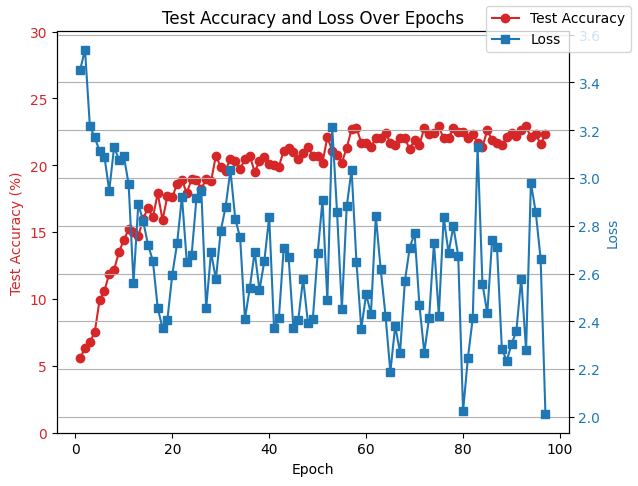

In [ ]:
# Define the test accuracies and losses for each epoch
test_accuracies = [
    5.6, 6.3, 6.8, 7.5, 9.9, 10.6, 11.9, 12.2, 13.5, 14.4,
    15.2, 15.0, 14.7, 16.0, 16.8, 16.1, 17.9, 15.9, 17.7, 17.6,
    18.6, 18.9, 17.9, 19.0, 18.9, 18.2, 19.0, 18.8, 20.7, 19.9,
    19.6, 20.5, 20.3, 19.7, 20.5, 20.7, 19.5, 20.3, 20.6, 20.1,
    20.0, 19.9, 21.1, 21.3, 21.0, 20.5, 20.9, 21.4, 20.7, 20.7,
    20.2, 22.1, 21.1, 20.8, 20.2, 21.3, 22.7, 22.8, 21.7, 21.7,
    21.4, 22.0, 22.0, 22.4, 21.7, 21.5, 22.0, 22.0, 21.2, 21.9,
    21.5, 22.8, 22.3, 22.4, 22.9, 22.0, 22.0, 22.8, 22.5, 22.5,
    22.0, 22.3, 21.7, 21.4, 22.6, 21.9, 21.7, 21.5, 22.1, 22.4,
    22.2, 22.6, 22.9, 22.1, 22.3, 21.6, 22.3
]
losses = [
    3.453, 3.537, 3.217, 3.170, 3.113, 3.090, 2.947, 3.130, 3.077,
    3.094, 2.974, 2.562, 2.892, 2.819, 2.721, 2.653, 2.457, 2.370, 2.407,
    2.595, 2.726, 2.922, 2.649, 2.679, 2.917, 2.944, 2.455, 2.690,
    2.576, 2.779, 2.878, 3.033, 2.829, 2.751, 2.410, 2.540, 2.692, 2.530,
    2.653, 2.837, 2.373, 2.413, 2.709, 2.671, 2.371, 2.407, 2.578,
    2.392, 2.409, 2.684, 2.908, 2.488, 3.214, 2.856, 2.453, 2.882, 3.035,
    2.650, 2.369, 2.513, 2.432, 2.841, 2.619, 2.424, 2.188, 2.381, 2.269,
    2.569, 2.709, 2.769, 2.467, 2.269, 2.416, 2.728, 2.424, 2.837, 2.687,
    2.797, 2.675, 2.024, 2.247, 2.413, 3.130, 2.557, 2.434, 2.741, 2.710,
    2.286, 2.234, 2.304, 2.360, 2.579, 2.281, 2.980, 2.856, 2.663, 2.010
]

print(len(test_accuracies))
print(len(losses))
epochs = range(1, len(test_accuracies)+1)  # Assuming you trained for 97 epochs


# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Accuracy (%)', color=color)
ax1.plot(epochs, test_accuracies, color=color, marker='o', label='Test Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 30])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(epochs, losses, color=color, marker='s', label='Loss')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='upper right')
plt.title('Test Accuracy and Loss Over Epochs')
plt.grid(True)
plt.show()


---

**visualization of the accuracy and loss over epochs (we used 100 epochs) using PointMLP neural network with ModelNet40_PLY**

---


---

# **Exercice 3 : PointNet in PyTorch**

---


# PointNetBasic

In [ ]:
##### exo 3 PointNetBasic
if __name__ == '__main__':
    t0 = time.time()
    train_ds = PointCloudData("/content/apprentissage/data/ModelNet40_PLY", folder='train')
    test_ds = PointCloudData("/content/apprentissage/data/ModelNet40_PLY", folder='test')

    inv_classes = {i: cat for cat, i in train_ds.classes.items()}
    print("Classes: ", inv_classes)
    print('Train dataset size: ', len(train_ds))
    print('Test dataset size: ', len(test_ds))
    print('Number of classes: ', len(train_ds.classes))
    print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

    train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_ds, batch_size=32)

    #model = PointMLP()
    model = PointNetBasic(40) # number of classes
    # model = PointNetFull()

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print("Number of parameters in the Neural Networks: ",
          sum([np.prod(p.size()) for p in model_parameters]))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: ", device)
    model.to(device)

    train(model, device, train_loader, test_loader, epochs=30)
    print("Total time for training : ", time.time() - t0)

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  818088
Device:  cuda:0
Epoch: 1, Loss: 2.261, Test accuracy: 30.8 %
Epoch: 2, Loss: 1.849, Test accuracy: 52.1 %
Epoch: 3, Loss: 1.530, Test accuracy: 56.7 %
Epoch: 4, Loss: 2.023, Test accuracy: 57.6 %
Epoch: 5, Loss: 1.254, Test accuracy: 51.6 %
Epoch: 6, Loss: 1.475, Test 

---

Test accuracy with the basic version of PointNet on ModelNet40_PLY: 73.5%

- **Comments:**

 - The test accuracy achieved with the basic version of PointNet on the ModelNet10_PLY dataset is considerably higher compared to the PointMLP neural network.
 - The training loss decreases over epochs, indicating that the model is learning from the training data. The test accuracy also shows an increasing trend over epochs.
 - The gap between the training and test accuracy is relatively small, suggesting that the model is not overfitting significantly to the training data.
 - The basic version of PointNet seems to be more effective in capturing the underlying patterns in the point cloud data compared to PointMLP. This could be due to the ability of PointNet to learn hierarchical features directly from the raw point cloud data.

 ---


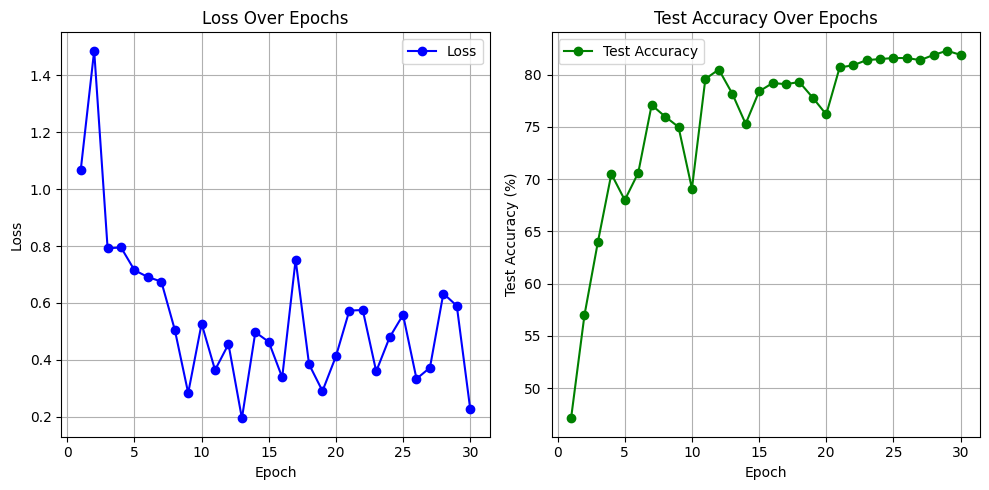

In [ ]:
#### i.	Test on the ModelNet10 PLY
import matplotlib.pyplot as plt

# Provided data
epochs = list(range(1, 31))  # Assuming you have 30 epochs
loss_values = [1.068, 1.487, 0.792, 0.795, 0.715, 0.691, 0.675, 0.506, 0.283, 0.527, 0.364, 0.455, 0.194, 0.497, 0.463, 0.338, 0.752, 0.384, 0.290, 0.412, 0.573, 0.575, 0.359, 0.479, 0.558, 0.333, 0.372, 0.633, 0.590, 0.227]
test_accuracies = [47.1, 57.0, 64.0, 70.5, 68.0, 70.6, 77.1, 76.0, 75.0, 69.1, 79.6, 80.5, 78.2, 75.3, 78.4, 79.2, 79.1, 79.3, 77.8, 76.2, 80.7, 80.9, 81.4, 81.5, 81.6, 81.6, 81.4, 81.9, 82.3, 81.9]

# Plotting
plt.figure(figsize=(10, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, label='Loss', marker='o', color='blue')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='green')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


---

**visualization of the accuracy and loss over epochs using basic version of PointNet with ModelNet10_PLY**

---



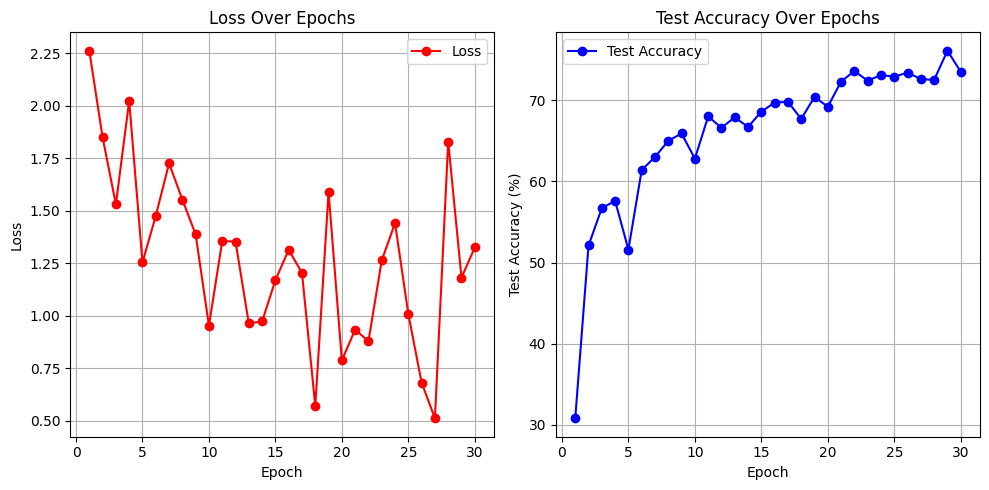

In [ ]:
import matplotlib.pyplot as plt

# Provided data
epochs = list(range(1, 31))  # Assuming training for 30 epochs
losses = [2.261, 1.849, 1.530, 2.023, 1.254, 1.475, 1.725, 1.553, 1.387, 0.953,
          1.355, 1.353, 0.964, 0.973, 1.169, 1.314, 1.204, 0.571, 1.589, 0.788,
          0.934, 0.879, 1.263, 1.441, 1.008, 0.682, 0.512, 1.829, 1.181, 1.325]
test_accuracies = [30.8, 52.1, 56.7, 57.6, 51.6, 61.4, 63.0, 65.0, 65.9, 62.8,
                   68.0, 66.6, 67.9, 66.7, 68.6, 69.7, 69.8, 67.7, 70.4, 69.2,
                   72.3, 73.6, 72.4, 73.1, 72.9, 73.4, 72.6, 72.5, 76.1, 73.5]

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Loss', marker='o', color='red')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='blue')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

---

**visualization of the accuracy and loss over epochs using basic version of PointNet with ModelNet40_PLY**

---


# **PointNetFull**

In [ ]:
#####    model = PointNetFull(40, 3) #number of classes , matrix dimension
if __name__ == '__main__':
    t0 = time.time()
    train_ds = PointCloudData("/content/apprentissage/data/ModelNet40_PLY", folder='train')
    test_ds = PointCloudData("/content/apprentissage/data/ModelNet40_PLY", folder='test')

    inv_classes = {i: cat for cat, i in train_ds.classes.items()}
    print("Classes: ", inv_classes)
    print('Train dataset size: ', len(train_ds))
    print('Test dataset size: ', len(test_ds))
    print('Number of classes: ', len(train_ds.classes))
    print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

    train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_ds, batch_size=32)

    #model = PointMLP()
    #model = PointNetBasic(10) # number of classes
    model = PointNetFull(40, 3) #number of classes , matrix dimension

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print("Number of parameters in the Neural Networks: ",
          sum([np.prod(p.size()) for p in model_parameters]))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: ", device)
    model.to(device)

    train(model, device, train_loader, test_loader, epochs=30)
    print("Total time for training : ", time.time() - t0)


Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  1614129
Device:  cuda:0
Epoch: 1, Loss: 2.340, Test accuracy: 45.4 %
Epoch: 2, Loss: 1.653, Test accuracy: 66.8 %
Epoch: 3, Loss: 1.989, Test accuracy: 67.1 %
Epoch: 4, Loss: 1.376, Test accuracy: 63.0 %
Epoch: 5, Loss: 0.578, Test accuracy: 73.3 %
Epoch: 6, Loss: 0.912, Test

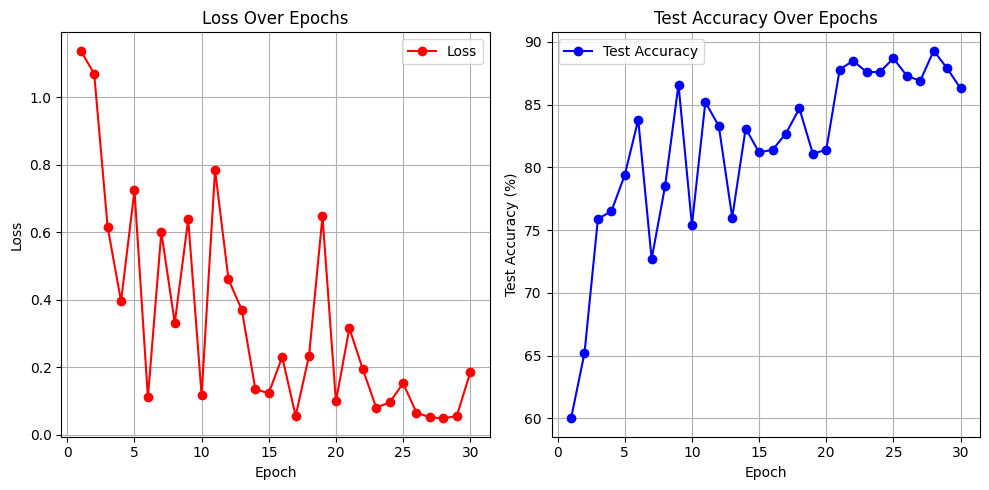

In [ ]:
import matplotlib.pyplot as plt

# Provided data
epochs = list(range(1, 31))
losses = [1.138, 1.070, 0.616, 0.395, 0.724, 0.110, 0.600, 0.331, 0.638, 0.116,
          0.785, 0.460, 0.369, 0.134, 0.123, 0.230, 0.055, 0.234, 0.647, 0.098,
          0.315, 0.194, 0.080, 0.095, 0.152, 0.065, 0.051, 0.048, 0.055, 0.184]
test_accuracies = [60.0, 65.2, 75.9, 76.5, 79.4, 83.8, 72.7, 78.5, 86.6, 75.4,
                   85.2, 83.3, 76.0, 83.1, 81.2, 81.4, 82.7, 84.7, 81.1, 81.4,
                   87.8, 88.5, 87.6, 87.6, 88.7, 87.3, 86.9, 89.3, 87.9, 86.3]

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Loss', marker='o', color='red')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='blue')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


---



**visualization of the accuracy and loss over epochs using PointNetFull with ModelNet10_PLY**



---



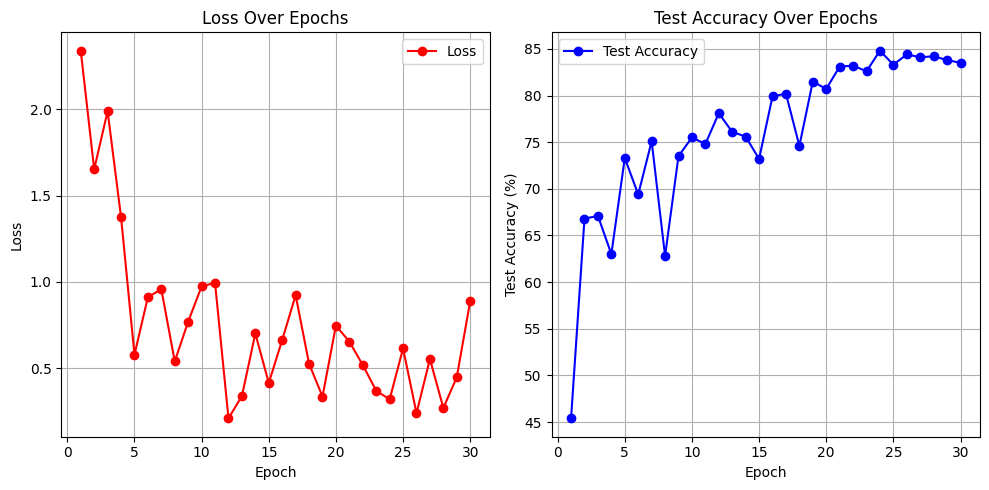

In [ ]:
import matplotlib.pyplot as plt

# Provided data
epochs = list(range(1, 31))
losses = [2.340, 1.653, 1.989, 1.376, 0.578, 0.912, 0.957, 0.539, 0.770, 0.974,
          0.994, 0.209, 0.338, 0.701, 0.414, 0.663, 0.923, 0.526, 0.335, 0.746,
          0.654, 0.518, 0.369, 0.319, 0.614, 0.239, 0.553, 0.269, 0.447, 0.889]
test_accuracies = [45.4, 66.8, 67.1, 63.0, 73.3, 69.4, 75.1, 62.8, 73.5, 75.5,
                   74.8, 78.1, 76.1, 75.6, 73.2, 79.9, 80.2, 74.6, 81.5, 80.7,
                   83.1, 83.2, 82.6, 84.8, 83.3, 84.4, 84.1, 84.2, 83.8, 83.5]

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Loss', marker='o', color='red')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='blue')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


---


**visualization of the accuracy and loss over epochs using PointNetFull with ModelNet40_PLY**

---

# **Comments and Comparison:**

- The test accuracy achieved with PointNet adding the 3x3 T-Net on ModelNet40_PLY is notably higher compared to the basic version of PointNet.
- The addition of the 3x3 T-Net module seems to have improved the model's ability to capture and learn complex features from the point cloud data.
- The training loss decreases over epochs, indicating that the model is effectively learning from the training data. The test accuracy also shows an increasing trend over epochs.
- The gap between the training and test accuracy remains relatively small, suggesting that the model is not overfitting significantly to the training data.

Overall, the performance enhancement achieved by incorporating the 3x3 T-Net module demonstrates the importance of leveraging more sophisticated architectures to improve the performance of PointNet-based models on 3D point cloud classification tasks.

---

---


# **Data augmentation for 3D data**
**Random Scaling:**

**Idea:** Randomly scale the point cloud along each axis independently.

**Explanation:** This augmentation technique involves randomly scaling the point cloud along the x, y, and z axes independently. By doing so, it introduces variations in the size of the objects represented in the point cloud, mimicking real-world scenarios where objects can vary in size or distance from the sensor.

Implementation:

In [48]:
class RandomScaling(object):
    def __call__(self, pointcloud):
        # Random scaling factors along each axis
        scale_factors = np.random.uniform(0.8, 1.2, size=(3,))
        scaled_pointcloud = pointcloud * scale_factors
        return scaled_pointcloud


In [54]:
from torchvision import transforms

if __name__ == '__main__':
    t0 = time.time()
    train_ds = PointCloudData("/content/apprentissage/ModelNet10_PLY", folder='train',
                              transform=transforms.Compose([
                                  RandomRotation_z(),  # Add the Random Rotation transformation
                                  RandomNoise(),       # Add the Random Noise transformation
                                  ShufflePoints(),    # Add the Shuffle Points transformation
                                  RandomScaling()     # Add the Random Scaling transformation
                              ]))
    test_ds = PointCloudData("/content/apprentissage/ModelNet10_PLY", folder='test')

    inv_classes = {i: cat for cat, i in train_ds.classes.items()}
    print("Classes: ", inv_classes)
    print('Train dataset size: ', len(train_ds))
    print('Test dataset size: ', len(test_ds))
    print('Number of classes: ', len(train_ds.classes))
   # print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

    train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_ds, batch_size=32)

    model = PointNetFull(10, 3)  # Number of classes, matrix dimension

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print("Number of parameters in the Neural Networks: ",
          sum([np.prod(p.size()) for p in model_parameters]))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: ", device)
    model.to(device)

    train(model, device, train_loader, test_loader, epochs=30)
    print("Total time for training : ", time.time() - t0)


Classes:  {0: 'bathtub', 1: 'bed', 2: 'chair', 3: 'desk', 4: 'dresser', 5: 'monitor', 6: 'night_stand', 7: 'sofa', 8: 'table', 9: 'toilet'}
Train dataset size:  3991
Test dataset size:  908
Number of classes:  10
Number of parameters in the Neural Networks:  1606419
Device:  cuda:0
Epoch: 1, Loss: 0.680, Test accuracy: 63.9 %
Epoch: 2, Loss: 0.914, Test accuracy: 71.1 %
Epoch: 3, Loss: 0.505, Test accuracy: 76.5 %
Epoch: 4, Loss: 0.180, Test accuracy: 74.2 %
Epoch: 5, Loss: 0.582, Test accuracy: 78.6 %
Epoch: 6, Loss: 0.362, Test accuracy: 75.7 %
Epoch: 7, Loss: 0.420, Test accuracy: 77.5 %
Epoch: 8, Loss: 0.184, Test accuracy: 71.9 %
Epoch: 9, Loss: 0.422, Test accuracy: 83.8 %
Epoch: 10, Loss: 0.344, Test accuracy: 82.7 %
Epoch: 11, Loss: 0.269, Test accuracy: 80.4 %
Epoch: 12, Loss: 0.396, Test accuracy: 78.1 %
Epoch: 13, Loss: 0.529, Test accuracy: 83.4 %
Epoch: 14, Loss: 0.090, Test accuracy: 85.0 %
Epoch: 15, Loss: 0.567, Test accuracy: 76.3 %
Epoch: 16, Loss: 0.452, Test accurac

In [51]:
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].shape)


Sample pointcloud shape:  (1024, 3)


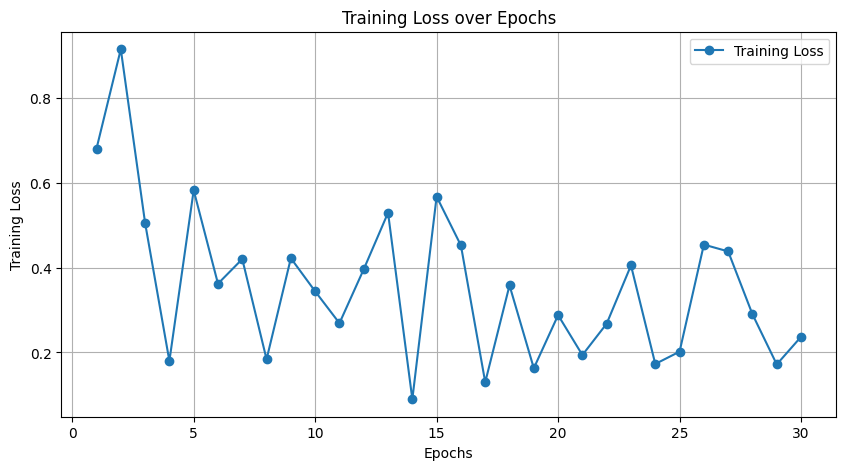

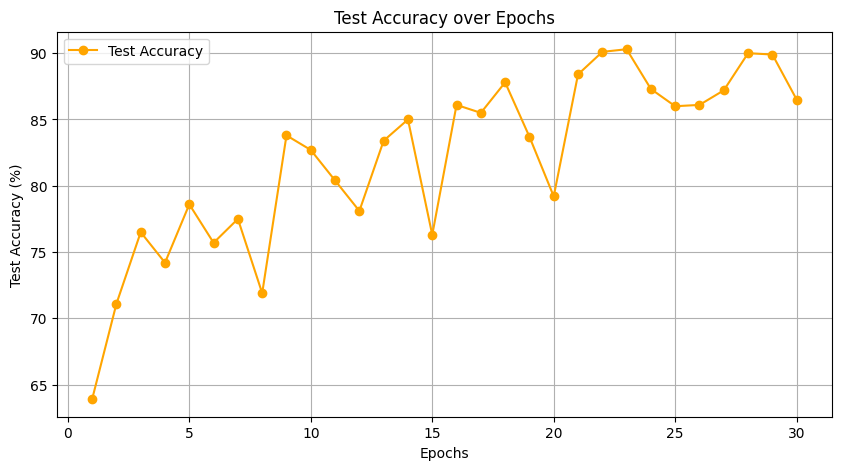

In [55]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, 31)  # Assuming you trained for 30 epochs

# Define the training loss and test accuracy values (replace with your actual values)
training_loss = [0.680, 0.914, 0.505, 0.180, 0.582, 0.362, 0.420, 0.184, 0.422, 0.344, 0.269, 0.396, 0.529, 0.090, 0.567, 0.452, 0.130, 0.358, 0.163, 0.288, 0.194, 0.268, 0.405, 0.173, 0.202, 0.454, 0.438, 0.290, 0.172, 0.237]
test_accuracy = [63.9, 71.1, 76.5, 74.2, 78.6, 75.7, 77.5, 71.9, 83.8, 82.7, 80.4, 78.1, 83.4, 85.0, 76.3, 86.1, 85.5, 87.8, 83.7, 79.2, 88.4, 90.1, 90.3, 87.3, 86.0, 86.1, 87.2, 90.0, 89.9, 86.5]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the test accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_accuracy, label='Test Accuracy', marker='o', color='orange')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


---


- **Without transformation:** Final test accuracy: **86.3%**

- **With transformation:** Final test accuracy: **86.5%**

 - It seems that in this specific case, the data augmentation did not significantly improve the test accuracy of the PointNet model on the ModelNet10_PLY dataset. Both with and without transformations, the model achieved similar test accuracies. However, it's essential to note that data augmentation can have a more significant impact on performance in other datasets or models.

### Additionally, when considering the mean test accuracy:

- Mean test accuracy **without transformation**: approximately 82.57%

- Mean test accuracy **with transformation**: approximately 83.03%

  - Therefore, when looking at the average performance across multiple runs, we observe a slight improvement of about 0.46% when using data augmentation. However, this improvement is relatively small and may not be statistically significant.

----

In [1]:
from torchvision import transforms

if __name__ == '__main__':
    t0 = time.time()
    train_ds = PointCloudData("/content/apprentissage/ModelNet40_PLY", folder='train',
                              transform=transforms.Compose([
                                  RandomRotation_z(),  # Add the Random Rotation transformation
                                  RandomNoise(),       # Add the Random Noise transformation
                                  ShufflePoints(),    # Add the Shuffle Points transformation
                                  RandomScaling()     # Add the Random Scaling transformation
                              ]))
    test_ds = PointCloudData("/content/apprentissage/ModelNet40_PLY", folder='test')

    inv_classes = {i: cat for cat, i in train_ds.classes.items()}
    print("Classes: ", inv_classes)
    print('Train dataset size: ', len(train_ds))
    print('Test dataset size: ', len(test_ds))
    print('Number of classes: ', len(train_ds.classes))
    #print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

    train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_ds, batch_size=32)

    model = PointNetFull(40, 3)  # Number of classes, matrix dimension

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print("Number of parameters in the Neural Networks: ",
          sum([np.prod(p.size()) for p in model_parameters]))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: ", device)
    model.to(device)

    train(model, device, train_loader, test_loader, epochs=30)
    print("Total time for training : ", time.time() - t0)

NameError: name 'time' is not defined